In [3]:
import os, sys, cv2
import seaborn as sn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Input
from keras.layers import Dense, Dropout, Flatten, LSTM
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, MaxPool1D, GaussianNoise, GlobalMaxPooling1D
from keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.layers import LeakyReLU
import tensorflow
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

2023-12-23 01:03:11.057911: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [11]:
# load the .npz file of features
f = np.load(os.getcwd()+"/MusicFeatures.npz")
S = f['spec'][:2048]
mfcc = f['mfcc'][:2048]
mel = f['mel'][:2048]
chroma = f['chroma'][:2048]
y = f['target'][:2048]

# split train-test data
S_train, S_test, mfcc_train, mfcc_test, mel_train, mel_test, chroma_train, chroma_test, y_train, y_test = train_test_split(S, mfcc, mel, chroma, y, test_size= 0.2)


In [ ]:
print(S.shape, mfcc.shape, mel.shape, chroma.shape, y.shape)

In [ ]:
# Spectrogram
maximum1 = np.amax(S_train)
S_train = S_train/np.amax(maximum1)
S_test = S_test/np.amax(maximum1)

S_train = S_train.astype(np.float32)
S_test = S_test.astype(np.float32)

N, row, col = S_train.shape
S_train = S_train.reshape((N, row, col, 1))

N, row, col = S_test.shape
S_test = S_test.reshape((N, row, col, 1))

In [ ]:
# MFCC
newtrain_mfcc = np.empty((mfcc_train.shape[0], 120, 600))
newtest_mfcc = np.empty((mfcc_test.shape[0], 120, 600))

for i in range(mfcc_train.shape[0]) :
    curr = mfcc_train[i]
    curr = cv2.resize(curr, (600, 120))
    newtrain_mfcc[i] = curr

mfcc_train = newtrain_mfcc

for i in range(mfcc_test.shape[0]) :

  curr = mfcc_test[i]
  curr = cv2.resize(curr, (600, 120))
  newtest_mfcc[i] = curr

mfcc_test = newtest_mfcc

mfcc_train = mfcc_train.astype(np.float32)
mfcc_test = mfcc_test.astype(np.float32)

N, row, col = mfcc_train.shape
mfcc_train = mfcc_train.reshape((N, row, col, 1))

N, row, col = mfcc_test.shape
mfcc_test = mfcc_test.reshape((N, row, col, 1))

mean_data = np.mean(mfcc_train)
std_data = np.std(mfcc_train)

mfcc_train = (mfcc_train - mean_data)/ std_data
mfcc_test = (mfcc_test - mean_data)/ std_data

In [ ]:
# Mel-Spectrogram

maximum = np.amax(mel_train)
mel_train = mel_train/np.amax(maximum)
mel_test = mel_test/np.amax(maximum)

mel_train = mel_train.astype(np.float32)
mel_test = mel_test.astype(np.float32)

N, row, col = mel_train.shape
mel_train = mel_train.reshape((N, row, col, 1))

N, row, col = mel_test.shape
mel_test = mel_test.reshape((N, row, col, 1))

In [ ]:
# Save Spectrogram train-test
np.savez_compressed(os.getcwd()+"/new_spectrogram_train_test.npz", S_train= S_train, S_test= S_test, y_train = y_train, y_test= y_test)

# Save MFCC train-test
np.savez_compressed(os.getcwd()+"/new_mfcc_train_test.npz", mfcc_train= mfcc_train, mfcc_test= mfcc_test, y_train = y_train, y_test= y_test)

# Save Mel-Spectrogram train-test
np.savez_compressed(os.getcwd()+"/new_mel_train_test.npz", mel_train= mel_train, mel_test= mel_test, y_train = y_train, y_test= y_test)


In [2]:
from keras.backend import set_session
from keras.backend import clear_session
from keras.backend import get_session
import tensorflow as tf
import gc
 
# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()
 
    try:
        del classifier # this is from global space - change this as you need
    except:
        pass
 
    print(gc.collect()) # if it does something you should see a number as output
 
    # use the same config as you used to create the session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tf.compat.v1.Session(config=config))

In [5]:
# Load Spectrogram Train-test data
spec_file = np.load(os.getcwd()+"/new_spectrogram_train_test.npz")

# Model 1 for Spectrogram
S_train = spec_file['S_train']
S_test = spec_file['S_test']
y_train = spec_file['y_train']
y_test = spec_file['y_test']

model = Sequential()
model.add(Conv2D(8, (3,3), activation= 'relu', input_shape= S_train[0].shape, padding= 'same'))
model.add(MaxPooling2D((4,4), padding= 'same'))
model.add(Conv2D(16, (3,3), activation= 'relu', padding= 'same'))
model.add(MaxPooling2D((4,4), padding= 'same'))
model.add(Conv2D(32, (3,3), activation= 'relu', padding= 'same'))
model.add(MaxPooling2D((4,4), padding= 'same'))
model.add(Conv2D(64, (3,3), activation= 'relu', padding= 'same'))
model.add(MaxPooling2D((4,4), padding= 'same'))
model.add(Conv2D(64, (3,3), activation= 'relu', padding= 'same'))
model.add(MaxPooling2D((4,4), padding= 'same'))
model.add(Flatten())
model.add(Dense(128, activation= 'relu'))
model.add(Dense(64, activation= 'relu'))
model.add(Dense(8, activation= 'softmax'))

model.compile(optimizer= 'Adam', loss= 'categorical_crossentropy')

model.summary()

# Train Model 1

checkpoint = ModelCheckpoint(os.getcwd()+"/models/new_spec_model_spectrogram1_{epoch:03d}.h5", period= 5)

reset_keras()
model.fit(S_train, y_train, epochs= 500, callbacks= [checkpoint], batch_size= 32, verbose= 1)
model.save(os.getcwd() + "/models/new_spec_model_spectrogram1.h5")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1025, 512, 8)      80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 257, 128, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 257, 128, 16)      1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 65, 32, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 65, 32, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 8, 32)        0

2023-12-23 00:13:31.496032: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22310 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:d6:00.0, compute capability: 8.6
2023-12-23 00:13:31.631339: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22310 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:d6:00.0, compute capability: 8.6


Epoch 1/500
52/52 [==============================] - 4s 33ms/step - loss: 2.0474
Epoch 2/500
52/52 [==============================] - 2s 33ms/step - loss: 1.9851
Epoch 3/500
52/52 [==============================] - 2s 33ms/step - loss: 1.8925
Epoch 4/500
52/52 [==============================] - 2s 33ms/step - loss: 1.8099
Epoch 5/500
52/52 [==============================] - 2s 33ms/step - loss: 1.7714
Epoch 6/500
52/52 [==============================] - 2s 31ms/step - loss: 1.7407
Epoch 7/500
52/52 [==============================] - 2s 32ms/step - loss: 1.6768
Epoch 8/500
52/52 [==============================] - 2s 31ms/step - loss: 1.6395
Epoch 9/500
52/52 [==============================] - 2s 32ms/step - loss: 1.6369
Epoch 10/500
52/52 [==============================] - 2s 32ms/step - loss: 1.5832
Epoch 11/500
52/52 [==============================] - 2s 32ms/step - loss: 1.5707
Epoch 12/500
52/52 [==============================] - 2s 38ms/step - loss: 1.5629
Epoch 13/500
52/52 [=====

(1638, 1025, 512, 1)
52/52 [==============================] - 1s 18ms/step
Train Accuracy:  1638 / 1638  =  100.0 %
13/13 [==============================] - 0s 17ms/step
Test Accuracy:  185 / 410  =  45.12 %
(8, 8)


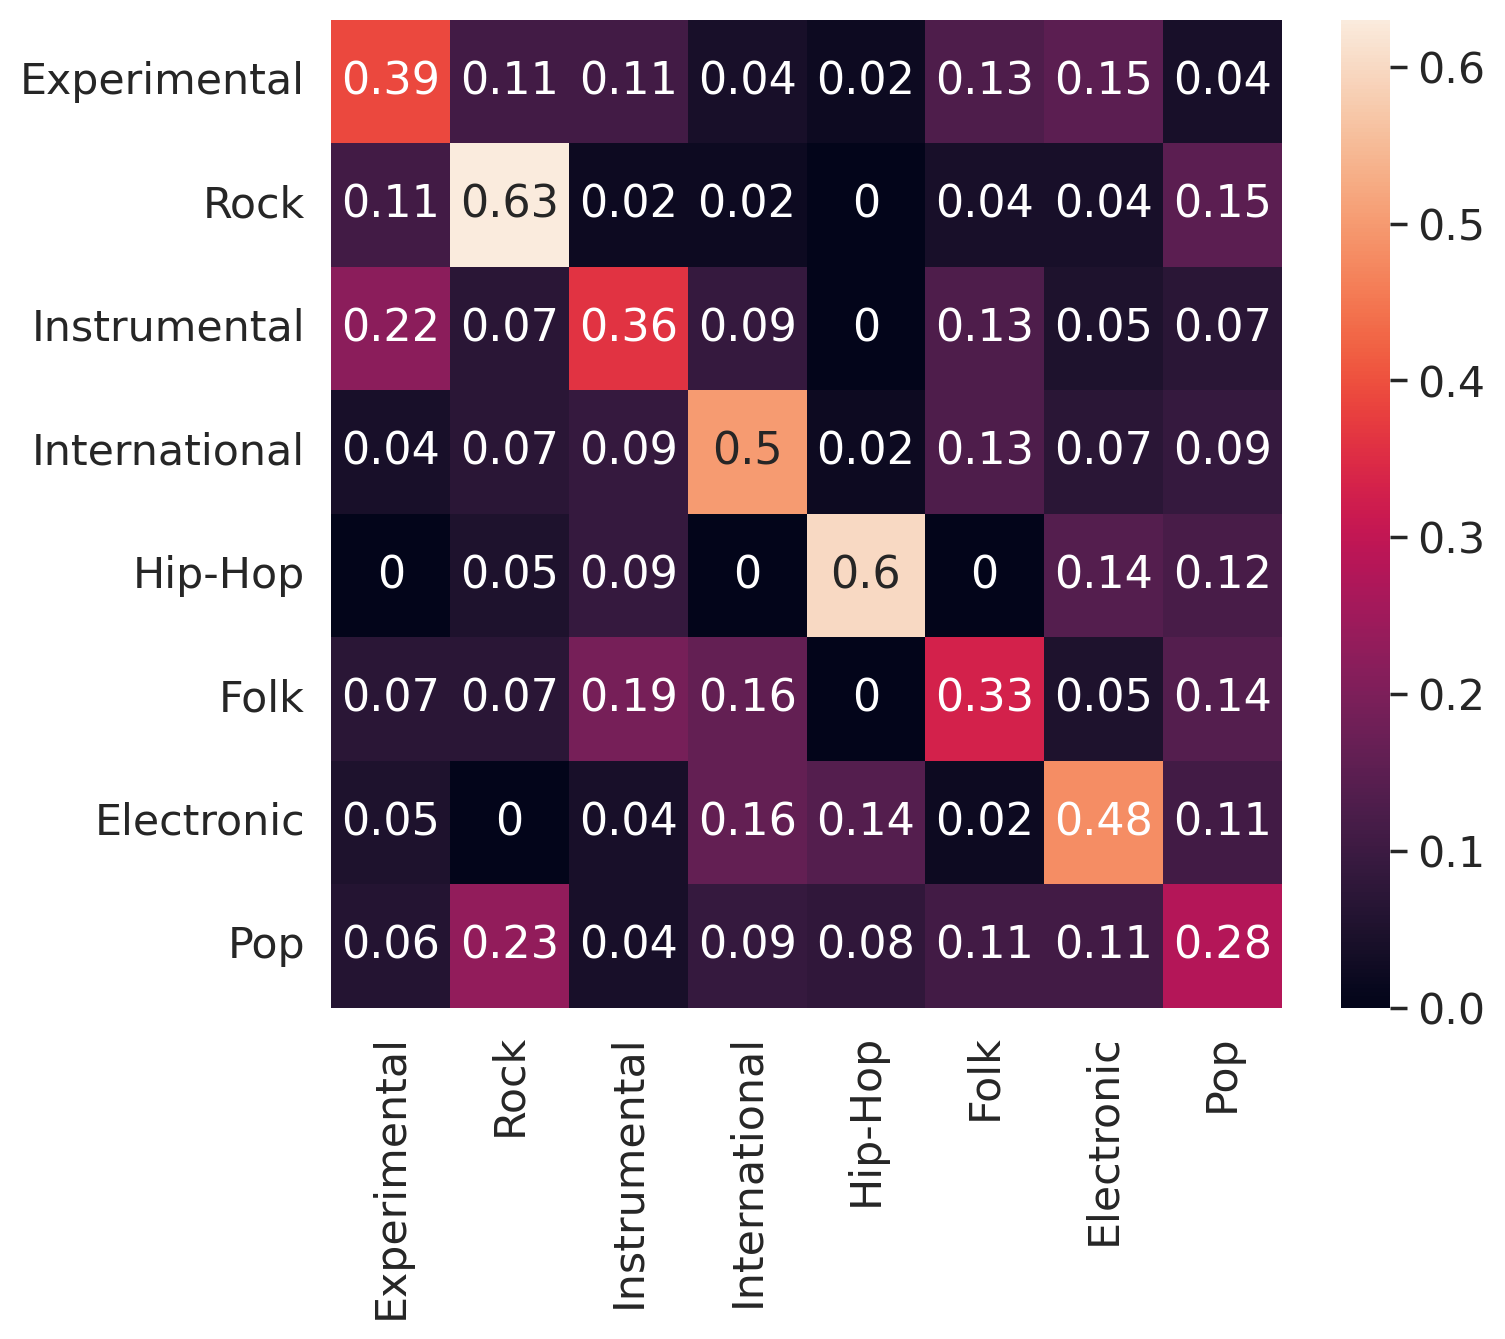

In [46]:
model = load_model(os.getcwd() + "/models/new_spec_model_spectrogram1.h5")

# Training Accuracy
y_pred = model.predict(S_train)
y_pred = np.argmax(y_pred, axis= -1)
y_true = np.argmax(y_train, axis= -1)

correct = len(y_pred) - np.count_nonzero(y_pred - y_true)
acc = correct/ len(y_pred)
acc = np.round(acc, 4) * 100

print("Train Accuracy: ", correct, "/", len(y_pred), " = ", acc, "%")

# # Testing Accuracy
y_pred = model.predict(S_test)
y_pred = np.argmax(y_pred, axis= -1)
y_true = np.argmax(y_test, axis= -1)

correct = len(y_pred) - np.count_nonzero(y_pred - y_true)
acc = correct/ len(y_pred)
acc = np.round(acc, 4) * 100

print("Test Accuracy: ", correct, "/", len(y_pred), " = ", acc, "%")

class_names = ['Experimental', 'Rock', 'Instrumental', 'International', 'Hip-Hop', 'Folk', 'Electronic', 'Pop']
conf_mat = confusion_matrix(y_true, y_pred, normalize= 'true')
print(conf_mat.shape)
conf_mat = np.round(conf_mat, 2)


conf_mat_df = pd.DataFrame(conf_mat, columns= class_names, index= class_names)

plt.figure(figsize = (8,7), dpi = 200)
sn.set(font_scale=1.4)
sn.heatmap(conf_mat_df, annot=True, annot_kws={"size": 16}) # font size
plt.tight_layout()
plt.savefig(os.getcwd() + "/new_spec_conf_mat1.png")


In [12]:
# calc precision, recall, f1-score
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names= class_names))

               precision    recall  f1-score   support

 Experimental       0.38      0.39      0.39        46
         Rock       0.53      0.63      0.58        54
 Instrumental       0.43      0.36      0.39        55
International       0.44      0.50      0.47        46
      Hip-Hop       0.71      0.60      0.65        57
         Folk       0.33      0.33      0.33        43
   Electronic       0.47      0.48      0.47        56
          Pop       0.29      0.28      0.29        53

     accuracy                           0.45       410
    macro avg       0.45      0.45      0.45       410
 weighted avg       0.45      0.45      0.45       410



In [16]:
# Spectrogram Model 2

S_train = spec_file['S_train']
S_test = spec_file['S_test']
y_train = spec_file['y_train']
y_test = spec_file['y_test']

model = Sequential()
model.add(Conv2D(8, (3,3), activation= 'relu', input_shape= S_train[0].shape, padding= 'same'))
model.add(MaxPooling2D((4,4), padding= 'same'))
model.add(Conv2D(16, (3,3), activation= 'relu', padding= 'same'))
model.add(MaxPooling2D((4,4), padding= 'same'))
model.add(Conv2D(32, (3,3), activation= 'relu', padding= 'same'))
model.add(MaxPooling2D((4,4), padding= 'same'))
model.add(Conv2D(64, (3,3), activation= 'relu', padding= 'same'))
model.add(MaxPooling2D((4,4), padding= 'same'))
model.add(Conv2D(64, (3,3), activation= 'relu', padding= 'same'))
model.add(MaxPooling2D((4,4), padding= 'same'))
model.add(Flatten())
model.add(Dense(128, activation= 'relu'))
model.add(Dense(64, activation= 'relu'))
model.add(Dense(8, activation= 'softmax'))

model.compile(optimizer= 'Adam', loss= 'categorical_crossentropy')

model.summary()

# Train Model 2

checkpoint = ModelCheckpoint(os.getcwd()+"/models/new_spec_model_spectrogram2_{epoch:03d}.h5", period= 5)

model.fit(S_train, y_train, epochs= 100, callbacks= [checkpoint], batch_size= 32, verbose= 1)
model.save(os.getcwd() + "/models/new_spec_model_spectrogram2.h5")



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 1025, 512, 8)      80        
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 257, 128, 8)      0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 257, 128, 16)      1168      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 65, 32, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 65, 32, 32)        4640      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 17, 8, 32)       

OSError: No file or directory found at /root/autodl-tmp/MusicGenreClassification/neural_network/cnn/models/new_model_spectrogram2.h5

52/52 [==============================] - 1s 21ms/step
Train Accuracy:  1638 / 1638  =  100.0 %
13/13 [==============================] - 0s 16ms/step
(410,) (410,)
Testing Accuracy:  193 / 410  =  47.07 %
(8, 8)


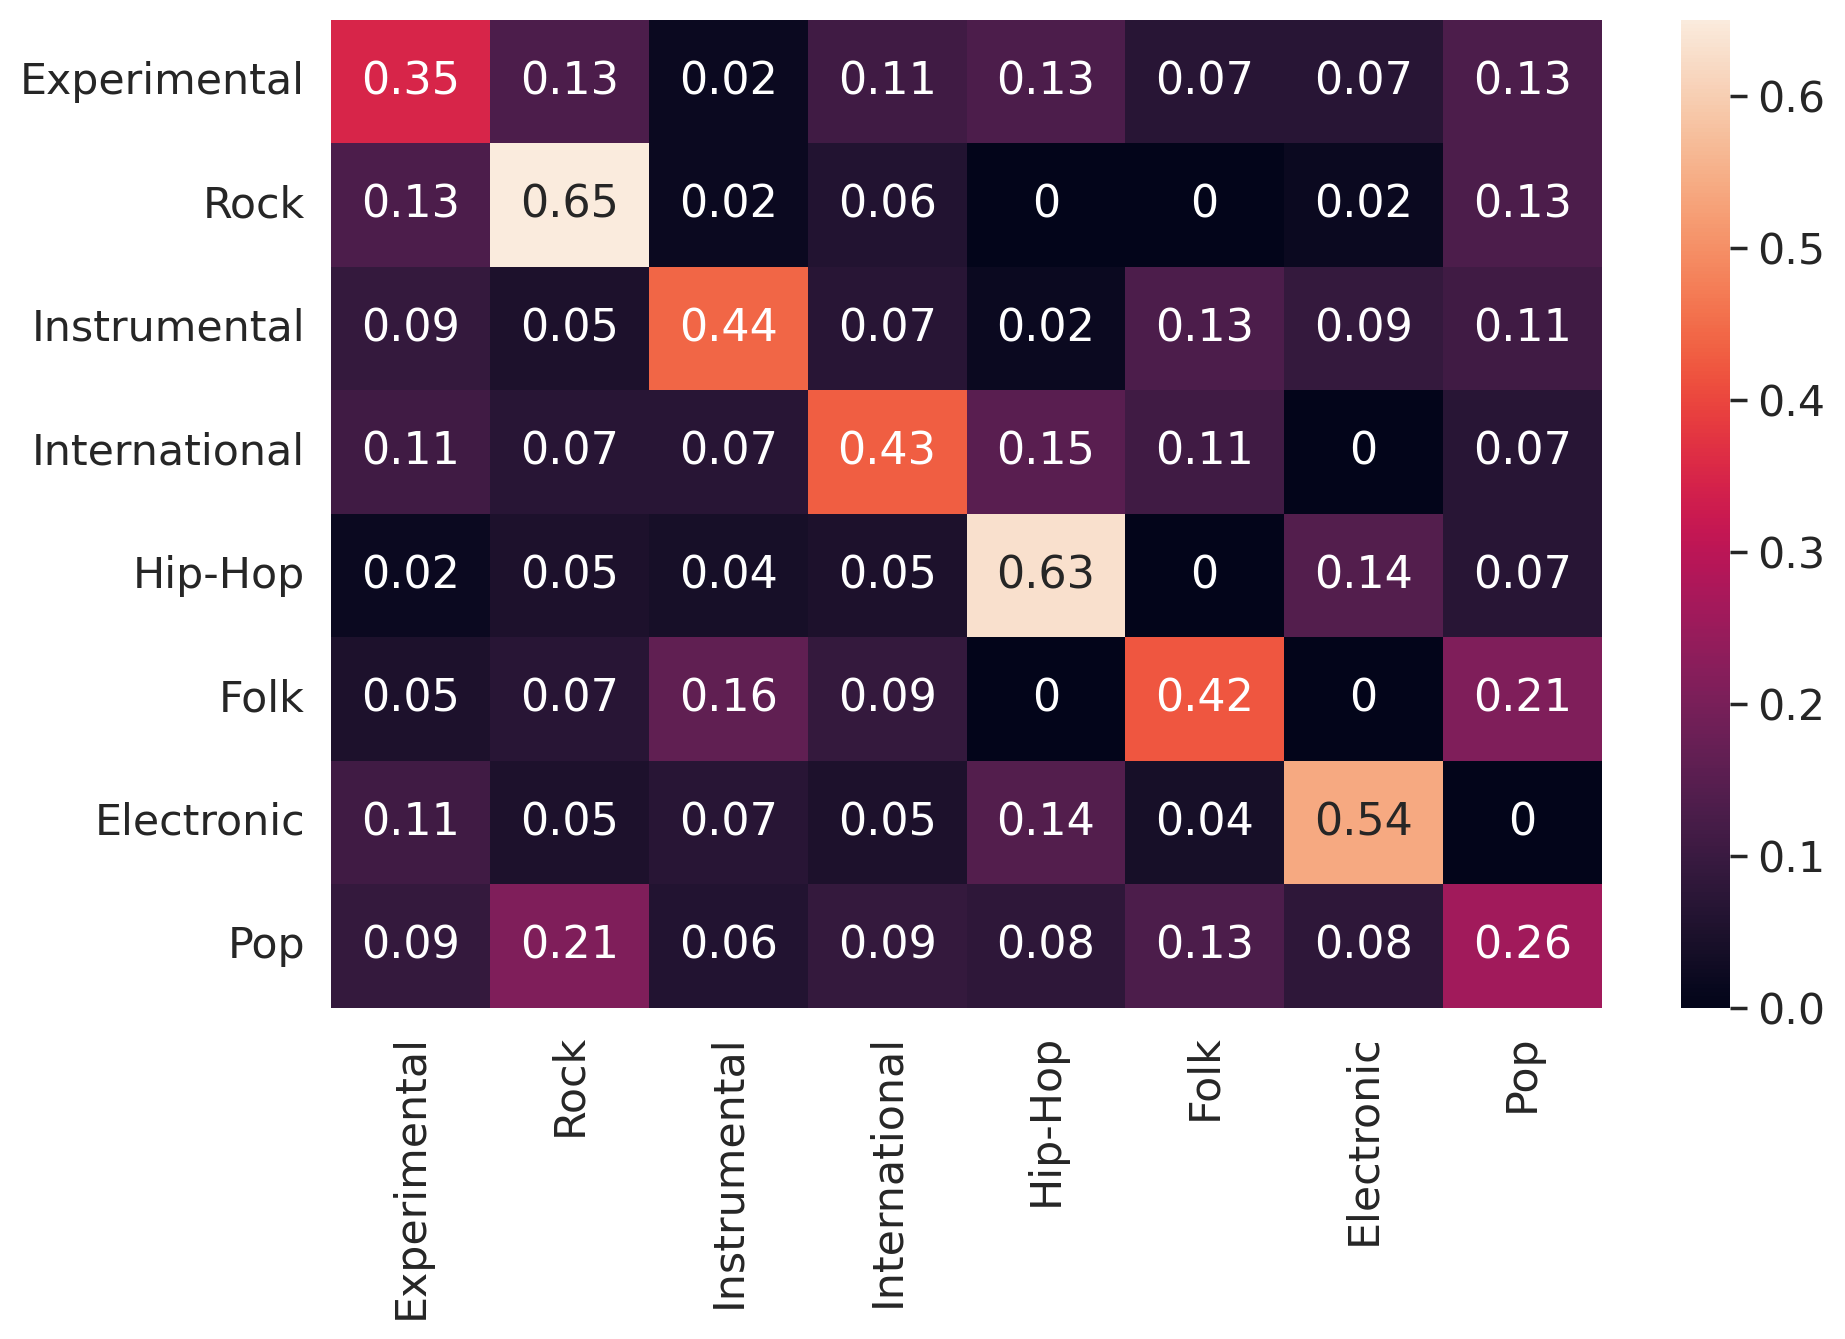

In [44]:
model = load_model(os.getcwd() + "/models/new_spec_model_spectrogram2.h5")


# Training Accuracy
y_pred = model.predict(S_train)
y_pred = np.argmax(y_pred, axis= -1)
y_true = np.argmax(y_train, axis= -1)

correct = len(y_pred) - np.count_nonzero(y_pred - y_true)
acc = correct/ len(y_pred)
acc = np.round(acc, 4) * 100

print("Train Accuracy: ", correct, "/", len(y_pred), " = ", acc, "%")

# Training Accuracy
y_pred = model.predict(S_test)
y_pred = np.argmax(y_pred, axis= -1)
y_true = np.argmax(y_test, axis= -1)

correct = len(y_pred) - np.count_nonzero(y_pred - y_true)
acc = correct/ len(y_pred)
acc = np.round(acc, 4) * 100

print("Testing Accuracy: ", correct, "/", len(y_pred), " = ", acc, "%")

class_names = ['Experimental', 'Rock', 'Instrumental', 'International', 'Hip-Hop', 'Folk', 'Electronic', 'Pop']
conf_mat = confusion_matrix(y_true, y_pred, normalize= 'true')
conf_mat = np.round(conf_mat, 2)
print(conf_mat.shape)
conf_mat_df = pd.DataFrame(conf_mat, columns= class_names, index= class_names)

plt.figure(figsize = (10,7), dpi = 200)
sn.set(font_scale=1.4)
sn.heatmap(conf_mat_df, annot=True, annot_kws={"size": 16}) # font size
plt.tight_layout()
plt.savefig(os.getcwd() + "/new_spec_conf_mat2.png")

In [20]:
# calc precision, recall, f1-score
print(classification_report(y_true, y_pred, target_names= class_names))

               precision    recall  f1-score   support

 Experimental       0.34      0.35      0.34        46
         Rock       0.52      0.65      0.58        54
 Instrumental       0.53      0.44      0.48        55
International       0.43      0.43      0.43        46
      Hip-Hop       0.58      0.63      0.61        57
         Folk       0.43      0.42      0.42        43
   Electronic       0.59      0.54      0.56        56
          Pop       0.29      0.26      0.27        53

     accuracy                           0.47       410
    macro avg       0.46      0.46      0.46       410
 weighted avg       0.47      0.47      0.47       410



In [24]:
# Load MFCC file
mfcc_file = np.load(os.getcwd()+"/new_mfcc_train_test.npz")
mfcc_train = mfcc_file['mfcc_train']
mfcc_test = mfcc_file['mfcc_test']
y_train = mfcc_file['y_train']
y_test = mfcc_file['y_test']

# Define model for MFCC
def get_model() :

    model = Sequential()
    model.add(Conv2D(16, (3,3), input_shape= mfcc_train[0].shape, activation= 'tanh', padding= 'same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((4,6), padding= 'same'))
    model.add(Conv2D(32, (3,3), input_shape= mfcc_train[0].shape, activation= 'tanh', padding= 'same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((4,6), padding= 'same'))
    model.add(Conv2D(64, (3,3), input_shape= mfcc_train[0].shape, activation= 'tanh', padding= 'same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((4,6), padding= 'same'))
    model.add(Flatten())
    # model.add(Dense(256, activation= 'tanh'))
    model.add(Dense(256, activation= 'tanh'))
    model.add(Dense(64, activation= 'tanh'))
    model.add(Dense(8, activation= 'softmax'))

    model.compile(optimizer= 'Adam', loss= 'categorical_crossentropy')

    model.summary()

    return model

In [35]:
# Function to get the majority vote
def get_majority(pred) :
    N = len(pred[0])
    vote = []
    for i in range(N) :
        candidates = [x[i] for x in pred]
        candidates = np.array(candidates)
        uniq, freq = np.unique(candidates, return_counts= True)
        vote.append(uniq[np.argmax(freq)])

    vote = np.array(vote)

    return vote

# Train Model 1

model1 = get_model()

kf = KFold(n_splits = 10)
for train_index, val_index in kf.split(mfcc_train, np.argmax(y_train, axis= -1)):

    kf_mfcc_train = mfcc_train[train_index]
    kf_X_val = mfcc_train[val_index]
    kf_y_train = y_train[train_index]
    kf_y_val = y_train[val_index]

    model1.fit(kf_mfcc_train, kf_y_train, validation_data= (kf_X_val, kf_y_val), epochs= 30, batch_size= 30, verbose= 1)
    model1.save(os.getcwd() + "/models/new_ensemble_mfcc1.h5")

# Train Model 2

model2 = get_model()

kf = KFold(n_splits = 10)
for train_index, val_index in kf.split(mfcc_train, np.argmax(y_train, axis= -1)):

    kf_mfcc_train = mfcc_train[train_index]
    kf_X_val = mfcc_train[val_index]
    kf_y_train = y_train[train_index]
    kf_y_val = y_train[val_index]

    model2.fit(kf_mfcc_train, kf_y_train, validation_data= (kf_X_val, kf_y_val), epochs= 30, batch_size= 30, verbose= 1)
    model2.save(os.getcwd() + "/models/new_ensemble_mfcc2.h5")

# Train Model 3

model3 = get_model()

kf = KFold(n_splits = 10)
for train_index, val_index in kf.split(mfcc_train, np.argmax(y_train, axis= -1)):

    kf_mfcc_train = mfcc_train[train_index]
    kf_X_val = mfcc_train[val_index]
    kf_y_train = y_train[train_index]
    kf_y_val = y_train[val_index]

    model3.fit(kf_mfcc_train, kf_y_train, validation_data= (kf_X_val, kf_y_val), epochs= 30, batch_size= 30, verbose= 1)
    model3.save(os.getcwd() + "/models/new_ensemble_mfcc3.h5")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 120, 600, 16)      160       
                                                                 
 batch_normalization_3 (Batc  (None, 120, 600, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 30, 100, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 30, 100, 32)       4640      
                                                                 
 batch_normalization_4 (Batc  (None, 30, 100, 32)      128       
 hNormalization)                                                 
                                                      

Epoch 1/30
50/50 [==============================] - 2s 25ms/step - loss: 1.8586 - val_loss: 2.1432
Epoch 2/30
50/50 [==============================] - 1s 15ms/step - loss: 1.7233 - val_loss: 2.4156
Epoch 3/30
50/50 [==============================] - 1s 15ms/step - loss: 1.6404 - val_loss: 2.6582
Epoch 4/30
50/50 [==============================] - 1s 15ms/step - loss: 1.5873 - val_loss: 2.3863
Epoch 5/30
50/50 [==============================] - 1s 15ms/step - loss: 1.5573 - val_loss: 2.3040
Epoch 6/30
50/50 [==============================] - 1s 15ms/step - loss: 1.5112 - val_loss: 2.5248
Epoch 7/30
50/50 [==============================] - 1s 15ms/step - loss: 1.4968 - val_loss: 2.4291
Epoch 8/30
50/50 [==============================] - 1s 15ms/step - loss: 1.4417 - val_loss: 2.3286
Epoch 9/30
50/50 [==============================] - 1s 15ms/step - loss: 1.4028 - val_loss: 2.0459
Epoch 10/30
50/50 [==============================] - 1s 15ms/step - loss: 1.3762 - val_loss: 1.9437
Epoch 11/

KeyboardInterrupt: 

In [12]:
del chroma, mel, S, mfcc

52/52 [==============================] - 0s 5ms/step
Train Accuracy:  1636 / 1638  =  99.88 %
13/13 [==============================] - 0s 6ms/step
Testing Accuracy:  152 / 410  =  37.07 %


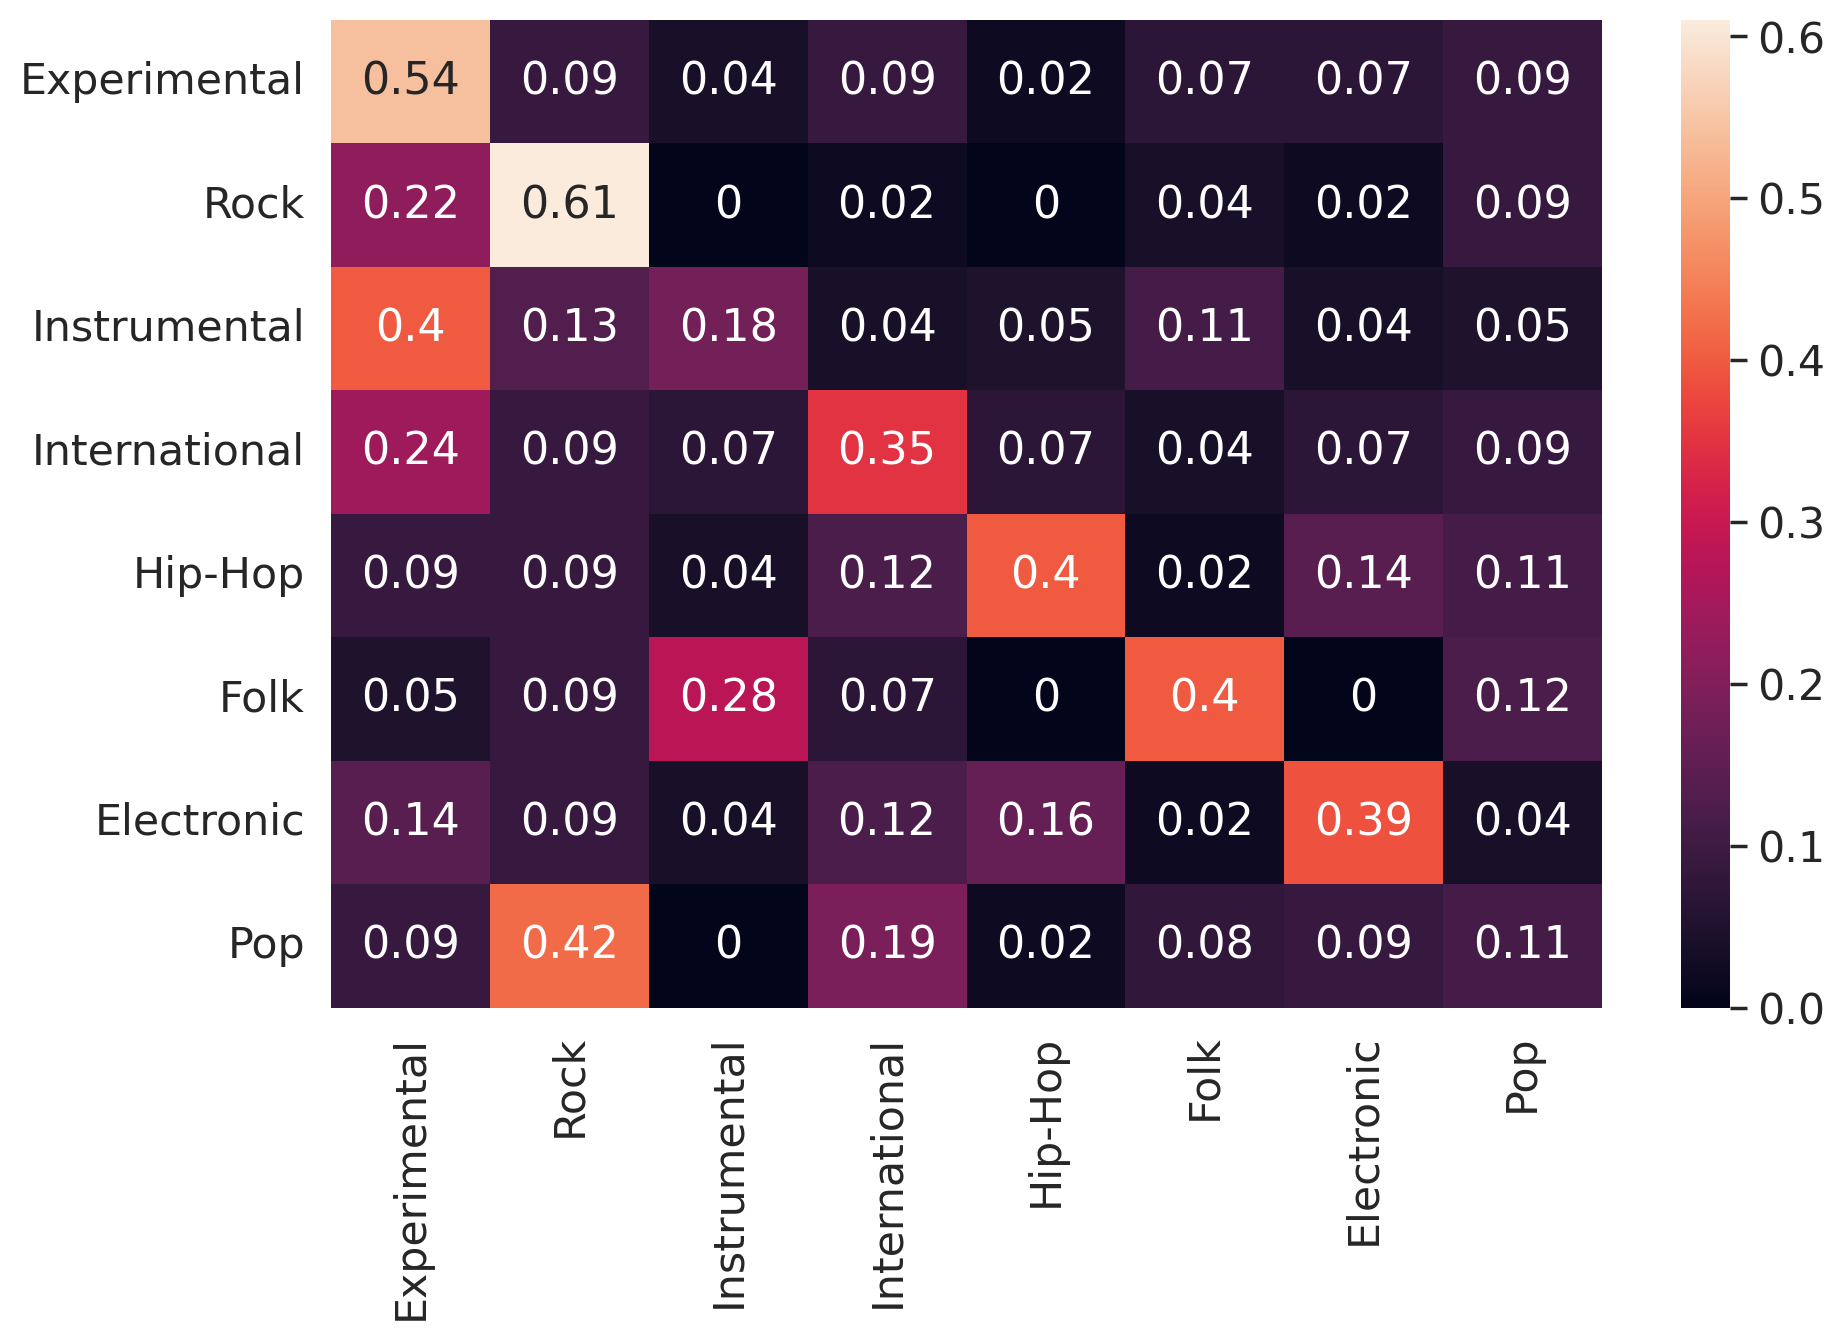

In [36]:
# Load the models
model1 = load_model(os.getcwd() + "/models/new_ensemble_mfcc1.h5")
model2 = load_model(os.getcwd() + "/models/new_ensemble_mfcc2.h5")
model3 = load_model(os.getcwd() + "/models/new_ensemble_mfcc3.h5")

# Training Accuracy
y_true = np.argmax(y_train, axis= -1)

y_pred1 = model1.predict(mfcc_train)
y_pred1 = np.argmax(y_pred1, axis= -1)

y_pred2 = model2.predict(mfcc_train)
y_pred2 = np.argmax(y_pred2, axis= -1)

y_pred3 = model3.predict(mfcc_train)
y_pred3 = np.argmax(y_pred3, axis= -1)

y_pred = [y_pred1, y_pred2, y_pred3]

y_pred = get_majority(y_pred)

correct = len(y_pred) - np.count_nonzero(y_pred - y_true)
acc = correct/ len(y_pred)
acc = np.round(acc, 4) * 100

print("Train Accuracy: ", correct, "/", len(y_pred), " = ", acc, "%")

# Test Model
y_true = np.argmax(y_test, axis= -1)

y_pred1 = model1.predict(mfcc_test)
y_pred1 = np.argmax(y_pred1, axis= -1)

y_pred2 = model2.predict(mfcc_test)
y_pred2 = np.argmax(y_pred2, axis= -1)

y_pred3 = model3.predict(mfcc_test)
y_pred3 = np.argmax(y_pred3, axis= -1)

y_pred = [y_pred1, y_pred2, y_pred3]

y_pred = get_majority(y_pred)


correct = len(y_pred) - np.count_nonzero(y_pred - y_true)
acc = correct/ len(y_pred)
acc = np.round(acc, 4) * 100

print("Testing Accuracy: ", correct, "/", len(y_pred), " = ", acc, "%")

class_names = ['Experimental', 'Rock', 'Instrumental', 'International', 'Hip-Hop', 'Folk', 'Electronic', 'Pop']
conf_mat = confusion_matrix(y_true, y_pred, normalize= 'true')
conf_mat = np.round(conf_mat, 2)

conf_mat_df = pd.DataFrame(conf_mat, columns= class_names, index= class_names)

plt.figure(figsize = (10,7), dpi = 200)
sn.set(font_scale=1.4)
sn.heatmap(conf_mat_df, annot=True, annot_kws={"size": 16}) # font size
plt.tight_layout()
plt.savefig(os.getcwd() + "/new_ensemble_mfcc_conf_mat.png")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 128, 512, 8)       80        
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 128, 8)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 128, 16)       1168      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 8, 32, 16)        0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 32, 32)         4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 2, 8, 32)        

2023-12-23 01:25:19.075122: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2023-12-23 01:25:21.805377: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


52/52 [==============================] - 6s 10ms/step - loss: 2.0706
Epoch 2/200
52/52 [==============================] - 0s 9ms/step - loss: 1.9679
Epoch 3/200
52/52 [==============================] - 0s 9ms/step - loss: 1.9159
Epoch 4/200
52/52 [==============================] - 0s 9ms/step - loss: 1.8939
Epoch 5/200
52/52 [==============================] - 1s 10ms/step - loss: 1.8609
Epoch 6/200
52/52 [==============================] - 0s 9ms/step - loss: 1.8059
Epoch 7/200
52/52 [==============================] - 0s 9ms/step - loss: 1.7363
Epoch 8/200
52/52 [==============================] - 0s 10ms/step - loss: 1.7108
Epoch 9/200
52/52 [==============================] - 1s 10ms/step - loss: 1.6381
Epoch 10/200
52/52 [==============================] - 1s 10ms/step - loss: 1.5882
Epoch 11/200
52/52 [==============================] - 0s 9ms/step - loss: 1.5747
Epoch 12/200
52/52 [==============================] - 0s 9ms/step - loss: 1.5880
Epoch 13/200
52/52 [========================

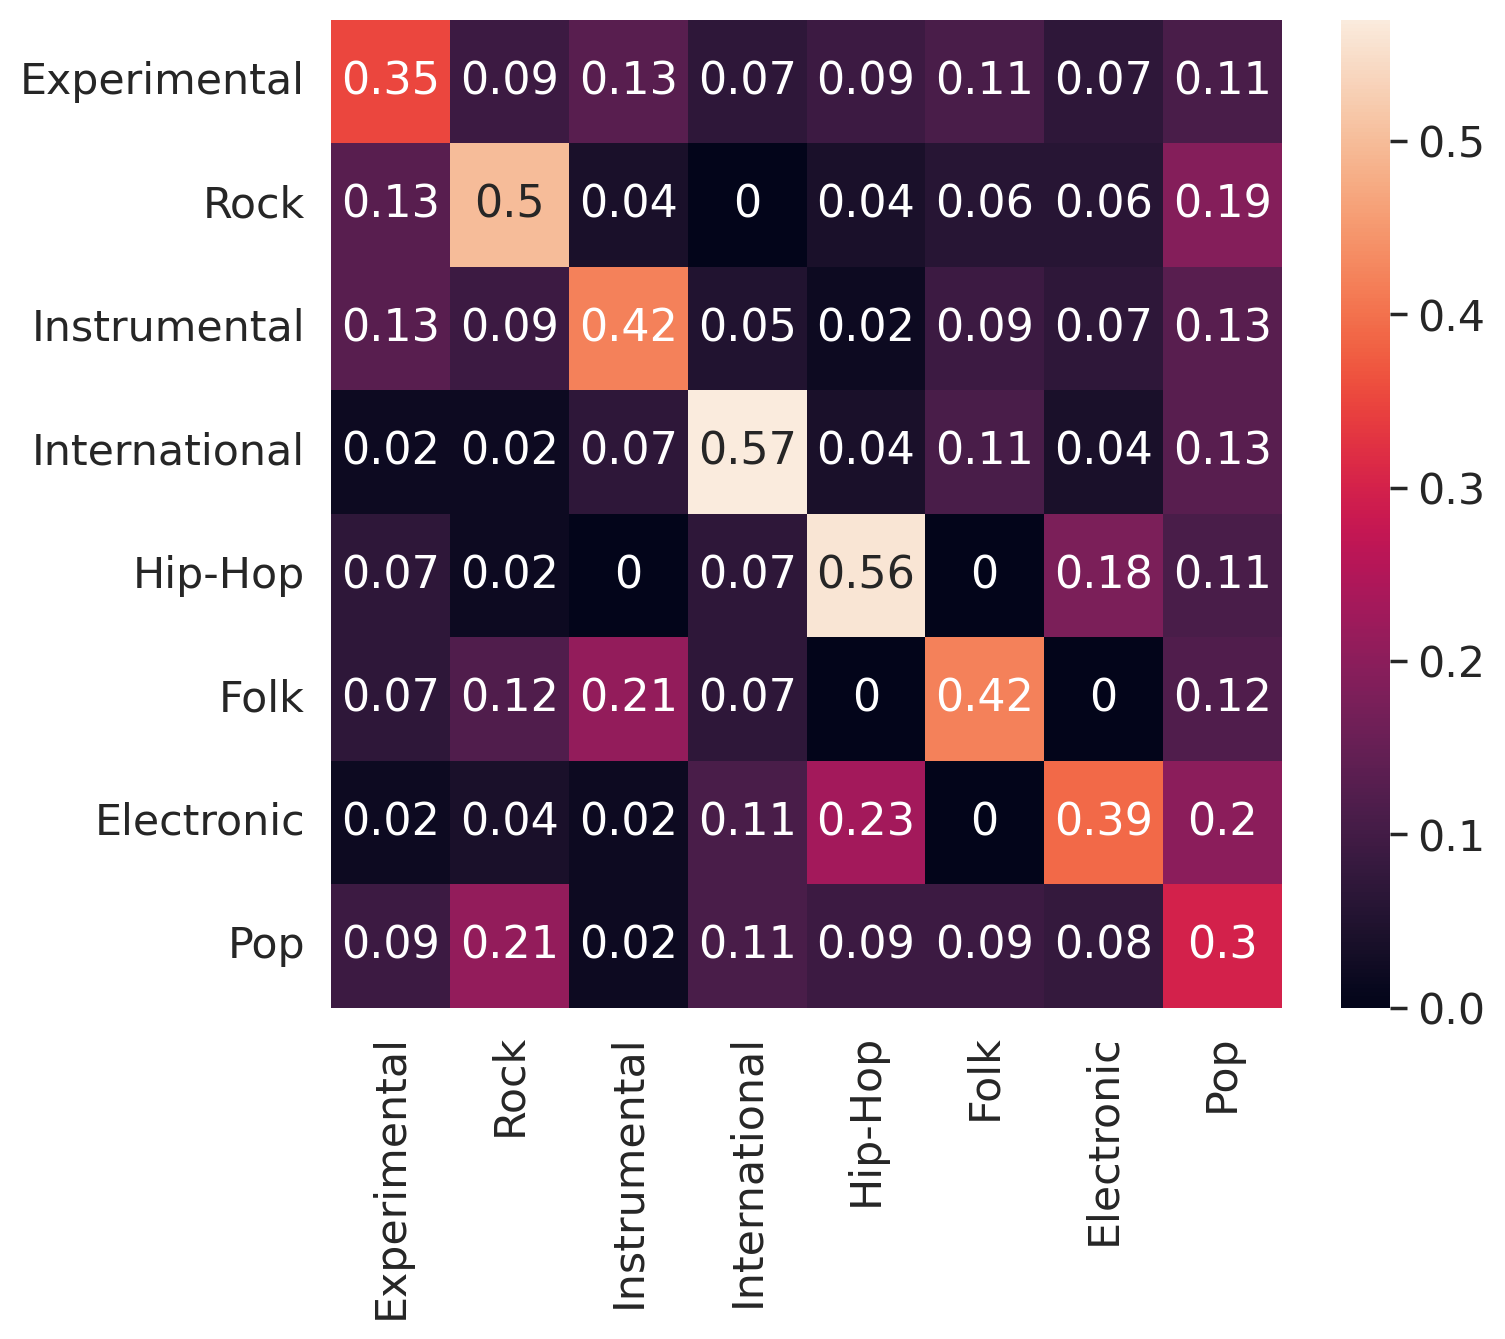

In [20]:
# Mel-Sprectrogram

# Load npz file of Mel-Spectrogram
file = np.load(os.getcwd()+"/new_mel_train_test.npz")
mel_train = file['mel_train']
mel_test = file['mel_test']
y_train = file['y_train']
y_test = file['y_test']

# Define the model
model = Sequential()
model.add(Conv2D(8, (3,3), activation= 'relu', input_shape= mel_train[0].shape, padding= 'same'))
model.add(MaxPooling2D((4,4), padding= 'same'))
model.add(Conv2D(16, (3,3), activation= 'relu', padding= 'same'))
model.add(MaxPooling2D((4,4), padding= 'same'))
model.add(Conv2D(32, (3,3), activation= 'relu', padding= 'same'))
model.add(MaxPooling2D((4,4), padding= 'same'))
model.add(Conv2D(64, (3,3), activation= 'relu', padding= 'same'))
model.add(MaxPooling2D((4,4), padding= 'same'))
model.add(Conv2D(64, (3,3), activation= 'relu', padding= 'same'))
model.add(MaxPooling2D((4,4), padding= 'same'))
model.add(Flatten())
model.add(Dense(64, activation= 'relu'))
model.add(Dense(8, activation= 'softmax'))

model.compile(optimizer= 'Adam', loss= 'categorical_crossentropy')

model.summary()


# Train Model

checkpoint = ModelCheckpoint(os.getcwd()+"/models/ensemble_model_melspectrogram1_{epoch:03d}.h5", period= 5)

model.fit(mel_train, y_train, epochs= 200, callbacks= [checkpoint], batch_size= 32, verbose= 1)
model.save(os.getcwd() + "/models/ensemble_model_melspectrogram1.h5")

# Load the model
model = load_model(os.getcwd() + "/models/ensemble_model_melspectrogram1.h5")


# Training Accuracy
y_pred = model.predict(mel_train)
y_pred = np.argmax(y_pred, axis= -1)
y_true = np.argmax(y_train, axis= -1)

correct = len(y_pred) - np.count_nonzero(y_pred - y_true)
acc = correct/ len(y_pred)
acc = np.round(acc, 4) * 100

print("Train Accuracy: ", correct, "/", len(y_pred), " = ", acc, "%")

# Testing Accuracy
y_pred = model.predict(mel_test)
y_pred = np.argmax(y_pred, axis= -1)
y_true = np.argmax(y_test, axis= -1)

correct = len(y_pred) - np.count_nonzero(y_pred - y_true)
acc = correct/ len(y_pred)
acc = np.round(acc, 4) * 100
print("Testing Accuracy", acc)

class_names = ['Experimental', 'Rock', 'Instrumental', 'International', 'Hip-Hop', 'Folk', 'Electronic', 'Pop']
conf_mat = confusion_matrix(y_true, y_pred, normalize= 'true')
conf_mat = np.round(conf_mat, 2)

conf_mat_df = pd.DataFrame(conf_mat, columns= class_names, index= class_names)

plt.figure(figsize = (8,7), dpi = 200)
sn.set(font_scale=1.4)
sn.heatmap(conf_mat_df, annot=True, annot_kws={"size": 16}) # font size
plt.tight_layout()
plt.savefig(os.getcwd() + "/ensemble_mel_conf_mat1.png")

In [49]:
# Load Spectrogram model 1
spec_file = np.load(os.getcwd()+"/new_spectrogram_train_test.npz")

S_train = spec_file['S_train']
S_test = spec_file['S_test']
y_train = spec_file['y_train']
y_test = spec_file['y_test']

model1 = load_model(os.getcwd() + "/models/new_spec_model_spectrogram1.h5")
print(model1.predict(S_train).shape)
# # Load Spectrogram model 2
# S_train = spec_file['S_train']
# S_test = spec_file['S_test']
# y_train = spec_file['y_train']
# y_test = spec_file['y_test']

# model2 = load_model(os.getcwd() + "/models/new_spec_model_spectrogram2.h5")

# # Load MFCC model 1,2 and 3
# mfcc_file = np.load(os.getcwd()+"/new_mfcc_train_test.npz")
# mfcc_train = mfcc_file['mfcc_train']
# mfcc_test = mfcc_file['mfcc_test']
# y_train = mfcc_file['y_train']
# y_test = mfcc_file['y_test']

# model3 = load_model(os.getcwd() + "/models/new_ensemble_mfcc1.h5")
# model4 = load_model(os.getcwd() + "/models/new_ensemble_mfcc2.h5")
# model5 = load_model(os.getcwd() + "/models/new_ensemble_mfcc3.h5")

# # Load Mel-spectrogram model
# file = np.load(os.getcwd()+"/new_mel_train_test.npz")
# mel_train = file['mel_train']
# mel_test = file['mel_test']
# y_train = file['y_train']
# y_test = file['y_test']

# model6 = load_model(os.getcwd() + "/models/ensemble_model_melspectrogram1.h5")

In [47]:
# Ground truth
y_true = np.argmax(y_train, axis= -1)

# Spectrogram model 1
y_pred1 = model1.predict(S_train)
y_pred1 = np.argmax(y_pred1, axis= -1)

# # Spectrogram model 2
# y_pred2 = model2.predict(S_train)
# y_pred2 = np.argmax(y_pred2, axis= -1)

# # MFCC model 1
# y_pred3 = model3.predict(mfcc_train)
# y_pred3 = np.argmax(y_pred3, axis= -1)

# # MFCC model 2
# y_pred4 = model4.predict(mfcc_train)
# y_pred4 = np.argmax(y_pred4, axis= -1)

# # MFCC model 3
# y_pred5 = model5.predict(mfcc_train)
# y_pred5 = np.argmax(y_pred5, axis= -1)

# # Mel-spectrogram 
# y_pred6 = model6.predict(mel_train)
# y_pred6 = np.argmax(y_pred6, axis= -1)

# print(y_pred1.shape, y_pred2.shape, y_pred3.shape, y_pred4.shape, y_pred5.shape, y_pred6.shape)
# # Get majority vote
# y_pred = [y_pred1, y_pred2, y_pred3, y_pred4, y_pred5, y_pred6]
# y_pred = get_majority(y_pred)

# correct = len(y_pred) - np.count_nonzero(y_pred - y_true)
# acc = correct/ len(y_pred)
# acc = np.round(acc, 4) * 100

# print("Training Accuracy: ", correct, "/", len(y_pred), " = ", acc, "%")

# # Test Model
# y_true = np.argmax(y_test, axis= -1)
# # Spectrogram model 1
# y_pred1 = model1.predict(S_test)
# y_pred1 = np.argmax(y_pred1, axis= -1)

# # Spectrogram model 2
# y_pred2 = model2.predict(S_test)
# y_pred2 = np.argmax(y_pred2, axis= -1)

# # MFCC model 1
# y_pred3 = model3.predict(mfcc_test)
# y_pred3 = np.argmax(y_pred3, axis= -1)

# # MFCC model 2
# y_pred4 = model4.predict(mfcc_test)
# y_pred4 = np.argmax(y_pred4, axis= -1)

# # MFCC model 3
# y_pred5 = model5.predict(mfcc_test)
# y_pred5 = np.argmax(y_pred5, axis= -1)

# # Mel-Spectrogram 
# y_pred6 = model6.predict(mel_test)
# y_pred6 = np.argmax(y_pred6, axis= -1)

# # Get majority vote
# print(y_pred1.shape, y_pred2.shape, y_pred3.shape, y_pred4.shape, y_pred5.shape, y_pred6.shape)
# y_pred = [y_pred1, y_pred2, y_pred3, y_pred4, y_pred5, y_pred6]
# y_pred = get_majority(y_pred)

# correct = len(y_pred) - np.count_nonzero(y_pred - y_true)
# acc = correct/ len(y_pred)
# acc = np.round(acc, 4) * 100
# print("Testing Accuracy: ", correct, "/", len(y_pred), " = ", acc, "%")

# class_names = ['Experimental', 'Rock', 'Instrumental', 'International', 'Hip-Hop', 'Folk', 'Electronic', 'Pop']
# conf_mat = confusion_matrix(y_true, y_pred, normalize= 'true')
# conf_mat = np.round(conf_mat, 2)

# conf_mat_df = pd.DataFrame(conf_mat, columns= class_names, index= class_names)

# plt.figure(figsize = (10,7), dpi = 200)
# sn.set(font_scale=1.4)
# sn.heatmap(conf_mat_df, annot=True, annot_kws={"size": 16}) # font size
# plt.tight_layout()
# plt.savefig(os.getcwd() + "/new_ensemble_conf_mat.png")

52/52 [==============================] - 0s 5ms/step
(13923,) (13923,) (1638,) (1638,) (1638,) (1638,)


IndexError: index 1638 is out of bounds for axis 0 with size 1638